<font size="6"> Training a Generative Adversarial Network (GAN) in Tensorflow <font/>

<font size="5"> Importing the required libraries <font/>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

<font size="5"> Loading the MNIST Dataset and Scaling image pixels to [0,1]  <font/>

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()

num_classes = int(np.max(y_train)+1)
print("There are ",num_classes, " classes in MNIST dataset.")

x_train = (x_train/255.0).astype('float32')
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
print("training dataset: ", x_train.shape)

input_shape = x_train.shape[1:]
y_train = keras.utils.to_categorical(y_train,num_classes)

There are  10  classes in MNIST dataset.
training dataset:  (60000, 28, 28, 1)


<font size="5"> Defining the GAN Class <font/>

In [3]:
class GAN():
    def __init__(self, latent_dim, discriminator, generator):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.discriminator = discriminator
        print("\nDiscriminator:")
        print(self.discriminator.summary())

        self.generator = generator
        print("\ngenerator:")
        print(self.generator.summary())

    def compile(self, g_optimizer,d_optimizer, loss_fn):
        print("Compiling the GAN...")
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        self.generator.compile(loss=self.loss_fn,optimizer=self.g_optimizer)
        self.discriminator.compile(loss=self.loss_fn,optimizer=self.d_optimizer)

    def train_discriminator(self,x,y,epochs,batch_size):
        real_images, one_hot_labels = x,y
        loss_values = []
        for _ in range(epochs):
            # Sample random points in the latent space
            # This is for the generator.
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            
            # Decode the noise to fake images.
            generated_images = self.generator(random_latent_vectors)

            # Combine them with real images. 
            combined_images = tf.concat([generated_images, real_images], axis=0)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
                loss_values.append(d_loss)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        return sum(loss_values)/len(loss_values)


    def train_generator(self,epochs,batch_size,beta):
        fn_loss_values = []
        class_loss_values = []

        for _ in range(epochs):
        
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            misleading_labels = tf.ones((batch_size, 1))
            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors)
                predictions = self.discriminator(fake_images)
                g_loss = self.loss_fn(misleading_labels, predictions)
            
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return g_loss


    def train(self,epochs,x,y):
        loss_dict = {'g_loss':[],'d_loss':[]}
        batch_size=512

        def batch_generator( x, y, batch_size):
            while True:
                idx = random.sample(range(x.shape[0]),batch_size)
                batch_x = x[idx,::]
                batch_y = y[idx,:]

                yield ( batch_x, batch_y )

        data_gen = batch_generator(x=x,y=y,batch_size=batch_size)
        for e in range(epochs):
            batch_x,batch_y = next(data_gen)
            d_loss = self.train_discriminator(batch_x,batch_y,epochs=5,batch_size=batch_size)
            g_loss = self.train_generator(epochs=5,batch_size=batch_size,beta=0.0)
            print("[",str(e),"] d_loss:","{0:.2f}".format(d_loss), "g_loss:","{0:.2f}".format(g_loss))
            loss_dict['g_loss'].append(g_loss)
            loss_dict['d_loss'].append(d_loss)

            if e % 5 == 0:
                self.sample_the_generator(e)
                self.plot_metrics(loss_dict,file_name='training_history')
            
            self.generator.save('generator.hdf5')
        
    def sample_the_generator(self,epoch):
        num_samples = 25
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(num_samples, self.latent_dim))

        fake_images = self.generator(random_latent_vectors)
        plt.cla()
        plt.figure(figsize=(25,25))
        plt.title("Synthesized images at epoch "+str(epoch),color='black')
        for i in range(num_samples):
            plt.subplot(5,5,i+1)
            plt.imshow(fake_images[i,::],cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.savefig("fake-samples/"+str(epoch)+".png")
        plt.savefig("current-fake-samples.png")
        plt.close()
    
    def plot_metrics(self,loss_dict, file_name):
        plt.cla()
        plt.figure()
        ax = plt.subplot(1,1,1)
        for i, metric in enumerate(loss_dict.keys()):
            y = loss_dict[metric]
            x = range(len(y))
            ax.plot(x,y, label=metric)
        ax.set_xlabel('epoch')
        ax.legend(loss_dict.keys(), loc='upper left')
        plt.tight_layout()
        plt.savefig(file_name+".png")

<font size="5"> Designing the Architecture of Discriminator and the Generator <font/>

In [4]:
latent_dim = 100

def make_generator(latent_dim):
    generator = keras.models.Sequential()
    generator.add(keras.layers.Dense(64*7*7, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Reshape((7, 7, 64)))
    generator.add(keras.layers.UpSampling2D(size=(2, 2)))
    generator.add(keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.UpSampling2D(size=(2, 2)))
    generator.add(keras.layers.Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
    return generator


def make_discriminator():
    discriminator = keras.models.Sequential()
    discriminator.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28,1), kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Dropout(0.3))
    discriminator.add(keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Dropout(0.3))
    discriminator.add(keras.layers.Flatten())
    discriminator.add(keras.layers.Dense(1, activation='sigmoid'))
    return discriminator

<font size="5"> Instantiating and Compiling the GAN <font/>

In [5]:
generator = make_generator(latent_dim)
discriminator = make_discriminator()
MNIST_GAN = GAN(latent_dim=latent_dim,discriminator=discriminator, generator=generator)
MNIST_GAN.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss_fn=keras.losses.BinaryCrossentropy(from_logits=False))


Discriminator:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 31

<font size="5"> Training the GAN <font/>

In [ ]:
MNIST_GAN.train(x=x_train,y=y_train,epochs=3000)

[ 0 ] d_loss: 0.68 g_loss: 0.73
[ 1 ] d_loss: 0.67 g_loss: 0.74
[ 2 ] d_loss: 0.66 g_loss: 0.76
[ 3 ] d_loss: 0.65 g_loss: 0.76
[ 4 ] d_loss: 0.65 g_loss: 0.75
[ 5 ] d_loss: 0.64 g_loss: 0.74
[ 6 ] d_loss: 0.63 g_loss: 0.73
[ 7 ] d_loss: 0.61 g_loss: 0.72
[ 8 ] d_loss: 0.58 g_loss: 0.71
[ 9 ] d_loss: 0.55 g_loss: 0.70
[ 10 ] d_loss: 0.52 g_loss: 0.70
[ 11 ] d_loss: 0.48 g_loss: 0.70
[ 12 ] d_loss: 0.45 g_loss: 0.70
[ 13 ] d_loss: 0.42 g_loss: 0.70
[ 14 ] d_loss: 0.40 g_loss: 0.70
[ 15 ] d_loss: 0.39 g_loss: 0.68
[ 16 ] d_loss: 0.39 g_loss: 0.66
[ 17 ] d_loss: 0.41 g_loss: 0.61
[ 18 ] d_loss: 0.47 g_loss: 0.56
[ 19 ] d_loss: 0.56 g_loss: 0.49
[ 20 ] d_loss: 0.62 g_loss: 0.46
[ 21 ] d_loss: 0.62 g_loss: 0.49
[ 22 ] d_loss: 0.53 g_loss: 0.78
[ 23 ] d_loss: 0.41 g_loss: 1.03
[ 24 ] d_loss: 0.43 g_loss: 0.97
[ 25 ] d_loss: 0.50 g_loss: 0.83
[ 26 ] d_loss: 0.57 g_loss: 0.73
[ 27 ] d_loss: 0.59 g_loss: 0.67
[ 28 ] d_loss: 0.59 g_loss: 0.65
[ 29 ] d_loss: 0.59 g_loss: 0.64
[ 30 ] d_loss: 0.58 

/tmp/ipykernel_131577/4054249495.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(25,25))
/tmp/ipykernel_131577/4054249495.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[ 96 ] d_loss: 0.62 g_loss: 0.85
[ 97 ] d_loss: 0.59 g_loss: 0.84
[ 98 ] d_loss: 0.57 g_loss: 0.91
[ 99 ] d_loss: 0.55 g_loss: 0.92
[ 100 ] d_loss: 0.54 g_loss: 0.90
[ 101 ] d_loss: 0.52 g_loss: 0.92
[ 102 ] d_loss: 0.52 g_loss: 0.92
[ 103 ] d_loss: 0.53 g_loss: 0.87
[ 104 ] d_loss: 0.54 g_loss: 0.89
[ 105 ] d_loss: 0.55 g_loss: 0.84
[ 106 ] d_loss: 0.57 g_loss: 0.82
[ 107 ] d_loss: 0.60 g_loss: 0.80
[ 108 ] d_loss: 0.62 g_loss: 0.73
[ 109 ] d_loss: 0.65 g_loss: 0.74
[ 110 ] d_loss: 0.67 g_loss: 0.75
[ 111 ] d_loss: 0.68 g_loss: 0.75
[ 112 ] d_loss: 0.67 g_loss: 0.81
[ 113 ] d_loss: 0.66 g_loss: 0.79
[ 114 ] d_loss: 0.65 g_loss: 0.84
[ 115 ] d_loss: 0.62 g_loss: 0.82
[ 116 ] d_loss: 0.61 g_loss: 0.84
[ 117 ] d_loss: 0.58 g_loss: 0.81
[ 118 ] d_loss: 0.56 g_loss: 0.86
[ 119 ] d_loss: 0.56 g_loss: 0.85
[ 120 ] d_loss: 0.55 g_loss: 0.83
[ 121 ] d_loss: 0.55 g_loss: 0.85
[ 122 ] d_loss: 0.54 g_loss: 0.84
[ 123 ] d_loss: 0.55 g_loss: 0.86
[ 124 ] d_loss: 0.56 g_loss: 0.83
[ 125 ] d_loss: 0.

<font size="5"> Analyzing the GAN's Training phase <font/>

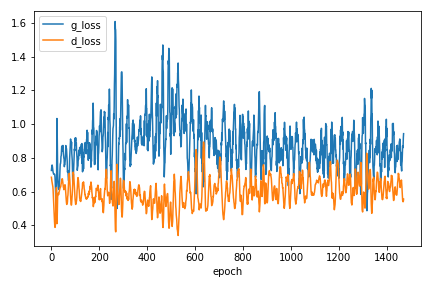

In [2]:
from IPython.display import Image
Image(filename='training_history.png') 

In [4]:
from PIL import Image
import glob

def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    print(frames)
    frame_one = frames[0]
    frame_one.save("Train.gif", format="GIF", append_images=frames,
                save_all=True, duration=300, loop=0)
make_gif("./fake-samples")

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4EAED70790>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4EAED70BE0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C40B250>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C4160D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C416130>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C416190>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C4161F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C416250>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C4162B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C416310>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C416370>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1800x1800 at 0x7F4E9C

<font size="5"> How Did the Generator Evolve and Improve? <font/>

<img src="Train.gif" width="750" align="center">